In [4]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import copy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
games_df = pd.read_csv('/content/games.csv')
games_df.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,1610612740,1610612759,2022,1610612740,126.0,0.484,0.926,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,1610612762,1610612764,2022,1610612762,120.0,0.488,0.952,...,16.0,40.0,1610612764,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,1610612739,1610612749,2022,1610612739,114.0,0.482,0.786,...,22.0,37.0,1610612749,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,1610612755,1610612765,2022,1610612755,113.0,0.441,0.909,...,27.0,49.0,1610612765,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,1610612737,1610612741,2022,1610612737,108.0,0.429,1.000,...,22.0,47.0,1610612741,110.0,0.500,0.773,0.292,20.0,47.0,0


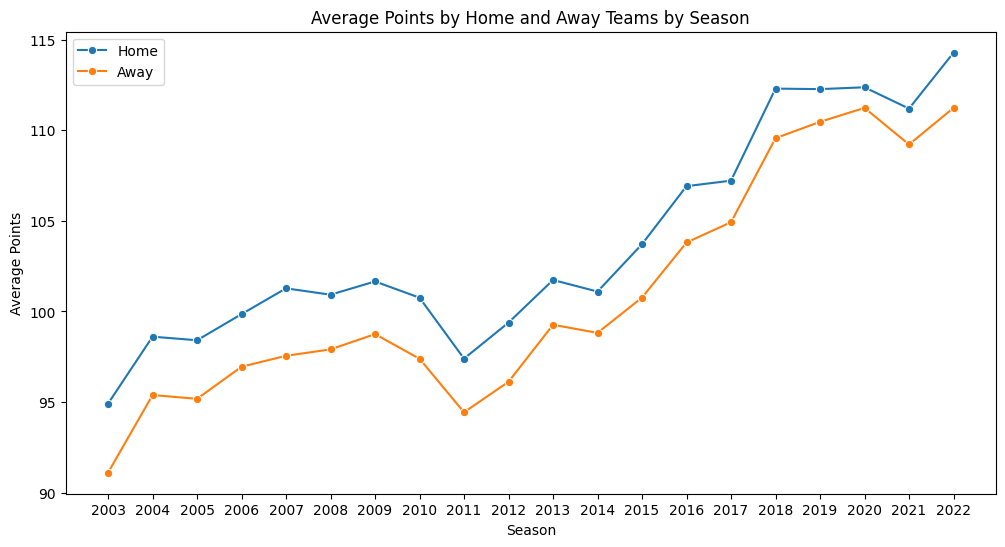

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert SEASON to integer
games_df['SEASON'] = games_df['SEASON'].astype(int)

# Calculate the average points by home and away teams by season
avg_points_by_season = games_df.groupby('SEASON')[['PTS_home', 'PTS_away']].mean()

# Plot the average points by home and away teams by season
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_points_by_season.reset_index(), x='SEASON', y='PTS_home', marker='o', label='Home')
sns.lineplot(data=avg_points_by_season.reset_index(), x='SEASON', y='PTS_away', marker='o', label='Away')
plt.title('Average Points by Home and Away Teams by Season')
plt.xlabel('Season')
plt.ylabel('Average Points')
plt.xticks(avg_points_by_season.index)  # Ensure x-axis ticks are integers
plt.legend()
plt.show()


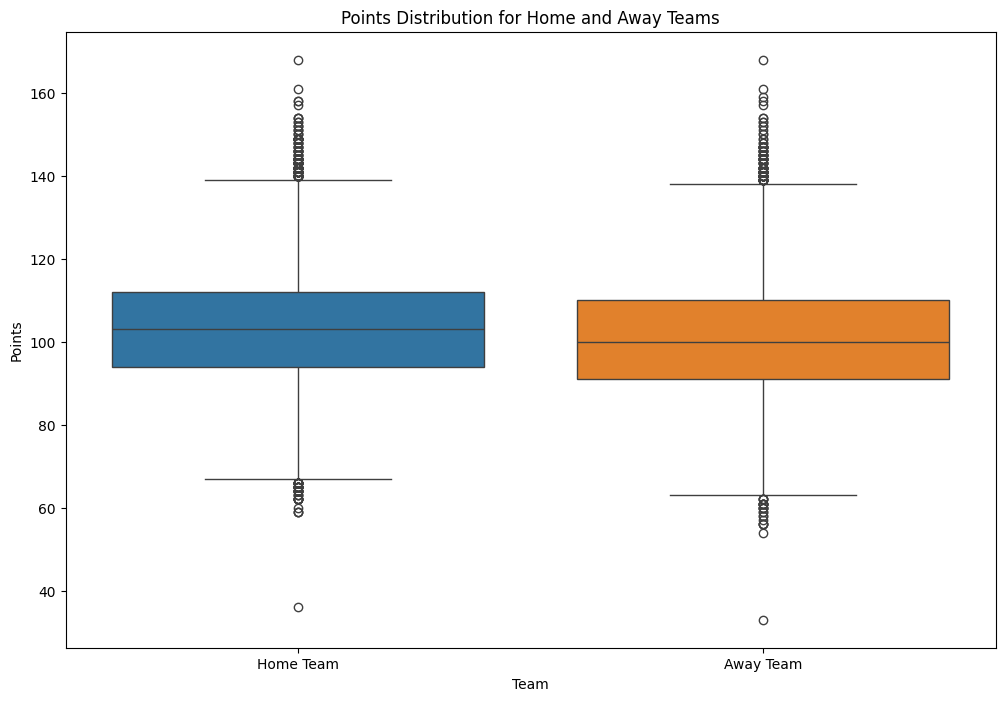

In [7]:
# Plot box plots of points distribution for home and away teams
plt.figure(figsize=(12, 8))
sns.boxplot(data=games_df[['PTS_home', 'PTS_away']])
plt.title('Points Distribution for Home and Away Teams')
plt.xlabel('Team')
plt.ylabel('Points')
plt.xticks([0, 1], ['Home Team', 'Away Team'])
plt.show()


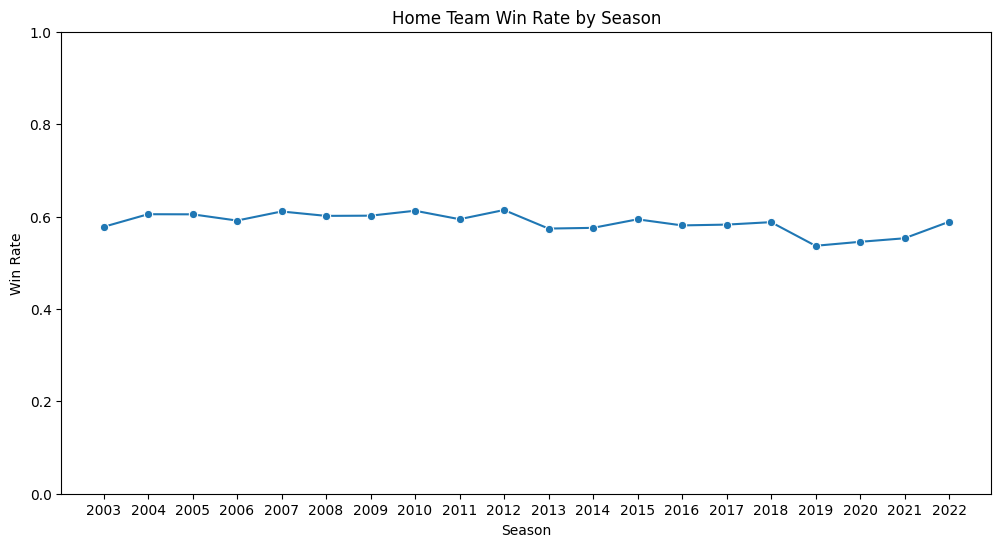

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert SEASON to integer
games_df['SEASON'] = games_df['SEASON'].astype(int)

# Calculate the win rate by season
win_rate_by_season = games_df.groupby('SEASON')['HOME_TEAM_WINS'].mean()

# Plot the home team win rate by season
plt.figure(figsize=(12, 6))
sns.lineplot(x=win_rate_by_season.index, y=win_rate_by_season.values, marker='o')
plt.title('Home Team Win Rate by Season')
plt.xlabel('Season')
plt.ylabel('Win Rate')
plt.ylim(0, 1)
plt.xticks(win_rate_by_season.index)  # Ensure x-axis ticks are integers
plt.show()


In [9]:
details_df = pd.read_csv('/content/games_details.csv')
details_df.head()

<ipython-input-9-ecaa194ce4a3>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  details_df = pd.read_csv('/content/games_details.csv')


,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,22200477,1610612759,SAS,San Antonio,1629641,Romeo Langford,Romeo,F,NaN,18:06,...,1.0,1.0,2.0,0.0,1.0,0.0,2.0,5.0,2.0,-2.0
1,22200477,1610612759,SAS,San Antonio,1631110,Jeremy Sochan,Jeremy,F,NaN,31:01,...,6.0,3.0,9.0,6.0,1.0,0.0,2.0,1.0,23.0,-14.0
2,22200477,1610612759,SAS,San Antonio,1627751,Jakob Poeltl,Jakob,C,NaN,21:42,...,1.0,3.0,4.0,1.0,1.0,0.0,2.0,4.0,13.0,-4.0
3,22200477,1610612759,SAS,San Antonio,1630170,Devin Vassell,Devin,G,NaN,30:20,...,0.0,9.0,9.0,5.0,3.0,0.0,2.0,1.0,10.0,-18.0
4,22200477,1610612759,SAS,San Antonio,1630200,Tre Jones,Tre,G,NaN,27:44,...,0.0,2.0,2.0,3.0,0.0,0.0,2.0,2.0,19.0,0.0


In [10]:
#For space considerations, we drop all games prior to 2017
drop_ids = []
for index, row in games_df.iterrows():
    year_str = row['GAME_DATE_EST']
    year = int(year_str[0:4])
    if(year < 2017):
        drop_ids.append(row['GAME_ID'])

games_df = games_df[~games_df['GAME_ID'].isin(drop_ids)]
details_df = details_df[~details_df['GAME_ID'].isin(drop_ids)]

games_df.reset_index(drop=True, inplace=True)
details_df.reset_index(drop=True, inplace=True)




In [11]:
num_rows = details_df.shape[0]
# Initialize the data structure
player_stats = {}


# Construct the data structure
for index, row in tqdm(details_df.iterrows(), total=num_rows, desc="Processing rows"):
    player_name = row['PLAYER_NAME']
    game_id = row['GAME_ID']
    player_statistics = row.drop(['PLAYER_NAME', 'GAME_ID', 'TEAM_ID', 'TEAM_CITY', 'PLAYER_ID', 'NICKNAME','START_POSITION','COMMENT','TEAM_ABBREVIATION'])
    if player_statistics.isnull().any():
        continue
    player_statistics = player_statistics.to_dict()
    if player_name not in player_stats:
        player_stats[player_name] = {}

    player_stats[player_name][game_id] = player_statistics

Processing rows: 100%|██████████| 208536/208536 [02:07<00:00, 1641.75it/s]


Now that player_stats is populated, let's build a hash from player to a sorted list of game_ids so that looking up the previous 3 games is easy

In [12]:
player_games_sorted = {}
for index, row in tqdm(details_df.iterrows(), total=num_rows, desc="Processing rows"):
    player_name = row['PLAYER_NAME']
    game_id = row['GAME_ID']

    if player_name not in player_games_sorted:
        player_games_sorted[player_name] = [game_id]
    else:
        player_games_sorted[player_name].append(game_id)
        player_games_sorted[player_name].sort()

Processing rows: 100%|██████████| 208536/208536 [00:16<00:00, 12504.18it/s]


In [13]:
def dict_entry_to_numpy(dict_entry):
    time_str = dict_entry['MIN']
    try:
        if ':' in time_str:
            minutes, seconds = map(int, time_str.split(':'))
            total_minutes = minutes * 60 + seconds
        else:
            total_minutes = float(time_str) * 60  # Assuming it's in minutes as a float
    except ValueError:
        total_minutes = 0.0  # Default to 0 if the format is incorrect or missing

    new_entry = dict_entry.copy()
    new_entry['MIN'] = total_minutes
    values_array = np.array(list(new_entry.values()))
    return values_array


In [14]:
# Function to find past three game IDs
def findPastThreeIDs(player_name, target_game=None):
    if player_name not in player_games_sorted:
        return np.zeros(20 * 3)  # Assuming each entry has 20 features and we need three entries
    foundarr = []
    for game_id in player_games_sorted[player_name]:
        if game_id == target_game:
            break
        try:
            foundarr.append(dict_entry_to_numpy(player_stats[player_name][game_id]))
        except KeyError:
            continue
    if len(foundarr) < 3:
        return np.concatenate([np.zeros(20)] * (3 - len(foundarr)) + foundarr)
    return np.concatenate(foundarr[-3:])

The following is example usage of the above funciton, getting the tensor for a player and the three previous starting games before the one specified

In [15]:
findPastThreeIDs("Romeo Langford", 22200477)

array([ 1.719e+03,  7.000e+00,  1.000e+01,  7.000e-01,  1.000e+00,
        2.000e+00,  5.000e-01,  4.000e+00,  4.000e+00,  1.000e+00,
        1.000e+00,  5.000e+00,  6.000e+00,  0.000e+00,  1.000e+00,
        1.000e+00,  2.000e+00,  3.000e+00,  1.900e+01, -3.000e+00,
        1.491e+03,  1.000e+00,  5.000e+00,  2.000e-01,  0.000e+00,
        2.000e+00,  0.000e+00,  1.000e+00,  2.000e+00,  5.000e-01,
        2.000e+00,  1.000e+00,  3.000e+00,  1.000e+00,  1.000e+00,
        1.000e+00,  0.000e+00,  1.000e+00,  3.000e+00, -1.200e+01,
        1.154e+03,  2.000e+00,  2.000e+00,  1.000e+00,  1.000e+00,
        1.000e+00,  1.000e+00,  1.000e+00,  2.000e+00,  5.000e-01,
        0.000e+00,  1.000e+00,  1.000e+00,  1.000e+00,  0.000e+00,
        1.000e+00,  0.000e+00,  1.000e+00,  6.000e+00,  3.000e+00])

In [16]:
# Function to get tensor from game ID
def getTensorFromID(id, game_details_df):
    filtered_df = game_details_df[(game_details_df['GAME_ID'] == id) & (game_details_df['START_POSITION'].notna())]
    tensor = np.array([], dtype=float)
    for index, row in filtered_df.iterrows():
        player_tensor = findPastThreeIDs(row['PLAYER_NAME'], id)
        tensor = np.concatenate((tensor, player_tensor))
    return tensor

Example usage of the above function. This allows us to get an input tensor for a specfied game. So, to train on data, simply run this function to get all input points on the games you want to train on.

In [17]:
getTensorFromID(22200477, details_df)

array([ 1.719e+03,  7.000e+00,  1.000e+01,  7.000e-01,  1.000e+00,
        2.000e+00,  5.000e-01,  4.000e+00,  4.000e+00,  1.000e+00,
        1.000e+00,  5.000e+00,  6.000e+00,  0.000e+00,  1.000e+00,
        1.000e+00,  2.000e+00,  3.000e+00,  1.900e+01, -3.000e+00,
        1.491e+03,  1.000e+00,  5.000e+00,  2.000e-01,  0.000e+00,
        2.000e+00,  0.000e+00,  1.000e+00,  2.000e+00,  5.000e-01,
        2.000e+00,  1.000e+00,  3.000e+00,  1.000e+00,  1.000e+00,
        1.000e+00,  0.000e+00,  1.000e+00,  3.000e+00, -1.200e+01,
        1.154e+03,  2.000e+00,  2.000e+00,  1.000e+00,  1.000e+00,
        1.000e+00,  1.000e+00,  1.000e+00,  2.000e+00,  5.000e-01,
        0.000e+00,  1.000e+00,  1.000e+00,  1.000e+00,  0.000e+00,
        1.000e+00,  0.000e+00,  1.000e+00,  6.000e+00,  3.000e+00,
        1.289e+03,  2.000e+00,  6.000e+00,  3.330e-01,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        1.000e+00,  4.000e+00,  5.000e+00,  3.000e+00,  0.000e

In [18]:
# Preparing training data
input_tensors = []
output_labels = []
output_scores = []

for index, row in tqdm(games_df.iterrows(), total=games_df.shape[0], desc="Preparing training data"):
    game_id = row['GAME_ID']
    home_team_wins = 1 if row['HOME_TEAM_WINS'] else 0
    home_team_score = row['PTS_home']
    away_team_score = row['PTS_away']

    tensor = getTensorFromID(game_id, details_df)
    input_tensors.append(tensor)
    output_labels.append(home_team_wins)
    output_scores.append([home_team_score, away_team_score])

# Determine the maximum tensor length
max_length = max(len(tensor) for tensor in input_tensors)

# Pad tensors to ensure consistent shape
def pad_tensor(tensor, max_length):
    padding = max(0, max_length - len(tensor))
    return np.pad(tensor, (0, padding), 'constant')

input_tensors = [pad_tensor(tensor, max_length) for tensor in input_tensors]

# Convert to numpy arrays
X = np.array(input_tensors)
y = np.array(output_labels)
y_scores = np.array(output_scores)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scores, X_test_scores, y_train_scores, y_test_scores = train_test_split(X, y_scores, test_size=0.2, random_state=42)

Preparing training data: 100%|██████████| 7984/7984 [03:21<00:00, 39.65it/s]


In [19]:
def predict_game_outcome_and_score(home_team_players, away_team_players):
    home_tensor = np.array([], dtype=float)
    away_tensor = np.array([], dtype=float)

    for player in home_team_players:
        home_tensor = np.concatenate((home_tensor, findPastThreeIDs(player, None)))

    for player in away_team_players:
        away_tensor = np.concatenate((away_tensor, findPastThreeIDs(player, None)))

    home_tensor = pad_tensor(home_tensor, max_length // 2)
    away_tensor = pad_tensor(away_tensor, max_length // 2)

    input_tensor = np.concatenate((home_tensor, away_tensor)).reshape(1, -1)

    scores = reg.predict(input_tensor)[0]
    home_team_score, away_team_score = int(round(scores[0])), int(round(scores[1]))

    # Determine the outcome based on predicted scores
    outcome = 1 if home_team_score > away_team_score else 0

    return outcome, (home_team_score, away_team_score)


In [20]:
def predict_game_outcome_and_score(home_team_players, away_team_players):
    max_players = 5  # Maximum number of players in the team

    if len(home_team_players) > max_players or len(away_team_players) > max_players:
        print("Error: More than 5 players entered on a team.")
        return None, None

    home_tensor = np.array([], dtype=float)
    away_tensor = np.array([], dtype=float)

    for player in home_team_players:
        if player not in player_stats:
            print(f"Error: Player {player} not found.")
            return None, None
        home_tensor = np.concatenate((home_tensor, findPastThreeIDs(player, None)))

    for player in away_team_players:
        if player not in player_stats:
            print(f"Error: Player {player} not found.")
            return None, None
        away_tensor = np.concatenate((away_tensor, findPastThreeIDs(player, None)))

    # Add empty tensors if less than five players are inputted
    while len(home_team_players) < max_players:
        home_tensor = np.concatenate((home_tensor, np.zeros(20 * 3)))
        home_team_players.append(None)  # To keep track of added empty tensors

    while len(away_team_players) < max_players:
        away_tensor = np.concatenate((away_tensor, np.zeros(20 * 3)))
        away_team_players.append(None)  # To keep track of added empty tensors

    home_tensor = pad_tensor(home_tensor, max_length // 2)
    away_tensor = pad_tensor(away_tensor, max_length // 2)

    input_tensor = np.concatenate((home_tensor, away_tensor)).reshape(1, -1)

    scores = best_reg.predict(input_tensor)[0]
    home_team_score, away_team_score = int(round(scores[0])), int(round(scores[1]))

    # Determine the outcome based on predicted scores
    outcome = 1 if home_team_score > away_team_score else 0

    return outcome, (home_team_score, away_team_score)

# # User input for home and away team players
# home_team_input = input("Enter the names of the home team players separated by commas: ").split(',')
# away_team_input = input("Enter the names of the away team players separated by commas: ").split(',')

# # Strip any leading/trailing spaces
# home_team_input = [player.strip() for player in home_team_input]
# away_team_input = [player.strip() for player in away_team_input]

# # Predict outcome and scores
# outcome, scores = predict_game_outcome_and_score(home_team_input, away_team_input)

# if outcome is not None:
#     print(f'Predicted Outcome: {"Home Team Wins" if outcome == 1 else "Away Team Wins"}')
#     print(f'Predicted Scores: Home Team {scores[0]} - Away Team {scores[1]}')

# For example, you can input this in the popup that comes when you run this cell:
# Bojan Bogdanovic, Austin Rivers, Mason Plumlee, Andre Drummond, Cedi Osman
# Kevon Harris, Terry Rozier, Udonis Haslem, Kelly Olynyk, Devin Booker

# Kemba Walker, Brandon Boston Jr., Jalen Green, Russell Westbrook, Bam Adebayo



In [21]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

pgridclf = {'n_neighbors': range(1, 21)}
gridclf = GridSearchCV(KNeighborsClassifier(), pgridclf, cv=5, scoring='accuracy')
gridclf.fit(X_train, y_train)

# Get best params
bestparam = gridclf.best_params_
bestscore = gridclf.best_score_

print(f"Best parameters for KNN Classifier: {bestparam}")
print(f"Best cross-validated accuracy for KNN Classifier: {bestscore:.2f}")

paramreg = {'n_neighbors': range(1, 21)}
gridreg = GridSearchCV(KNeighborsRegressor(), paramreg, cv=5, scoring='neg_mean_squared_error')
gridreg.fit(X_train_scores, y_train_scores)

# Get best params
bestregparams = gridreg.best_params_
bestregscore = gridreg.best_score_

print(f"Best parameters for KNN Regressor: {bestregparams}")
print(f"Best cross-validated negative MSE for KNN Regressor: {bestregscore:.2f}")

bestclf = gridclf.best_estimator_
bestreg = gridreg.best_estimator_

print(f"Best parameters for KNN Regressor: {bestregparams}")
print(f"Best parameters for KNN Regressor: {bestregparams}")


Best parameters for KNN Classifier: {'n_neighbors': 15}
Best cross-validated accuracy for KNN Classifier: 0.55
Best parameters for KNN Regressor: {'n_neighbors': 20}
Best cross-validated negative MSE for KNN Regressor: -164.41
Best parameters for KNN Regressor: {'n_neighbors': 20}
Best parameters for KNN Regressor: {'n_neighbors': 20}


In [22]:
import numpy as np

def predict_game(home_players, away_players):
    max_players = 5

    if len(home_players) > max_players or len(away_players) > max_players:
        print("Error: More than 5 players entered on a team.")
        return None, None

    home_tensor = np.array([], dtype=float)
    away_tensor = np.array([], dtype=float)

    for player in home_players:
        if player not in player_stats:
            print(f"Error: Player {player} not found.")
            return None, None
        home_tensor = np.concatenate((home_tensor, findPastThreeIDs(player, None)))

    for player in away_players:
        if player not in player_stats:
            print(f"Error: Player {player} not found.")
            return None, None
        away_tensor = np.concatenate((away_tensor, findPastThreeIDs(player, None)))

    home_tensor = pad_tensor(home_tensor, max_length // 2)
    away_tensor = pad_tensor(away_tensor, max_length // 2)

    input_tensor = np.concatenate((home_tensor, away_tensor)).reshape(1, -1)

    win_prob = bestclf.predict_proba(input_tensor)[0][1]

    scores = bestreg.predict(input_tensor)[0]
    home_score, away_score = int(round(scores[0])), int(round(scores[1]))

    return win_prob, (home_score, away_score)

# test
home_team = ["LeBron James", "Anthony Davis", "Russell Westbrook", "Dennis Schroder", "Austin Reaves"]
away_team = ["Stephen Curry", "Klay Thompson", "Draymond Green", "Andrew Wiggins", "Jordan Poole"]

win_prob, scores = predict_game(home_team, away_team)

if win_prob is not None:
    print(f"Home team win probability: {win_prob:.2f}")
    print(f'Predicted Scores: Home Team {scores[0]} - Away Team {scores[1]}')

    if win_prob > 0.5:
        home_odds = -100 / (win_prob - 1)
        away_odds = 100 / win_prob
    else:
        home_odds = 100 / (1 - win_prob)
        away_odds = -100 / win_prob

    print(f"Implied Odds: Home Team {int(round(home_odds))} - Away Team {int(round(away_odds))}")


Home team win probability: 0.60
Predicted Scores: Home Team 110 - Away Team 112
Implied Odds: Home Team 250 - Away Team 167


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, mean_squared_error,  confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns



Best KNN Classifier Accuracy: 0.53


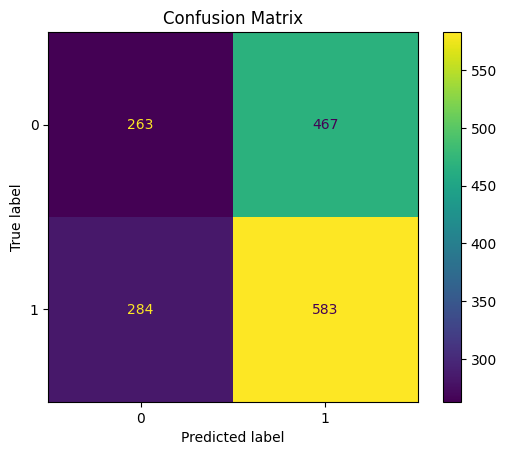

In [24]:
# Predict and evaluate the classifier
y_pred = bestclf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Best KNN Classifier Accuracy: {accuracy:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()



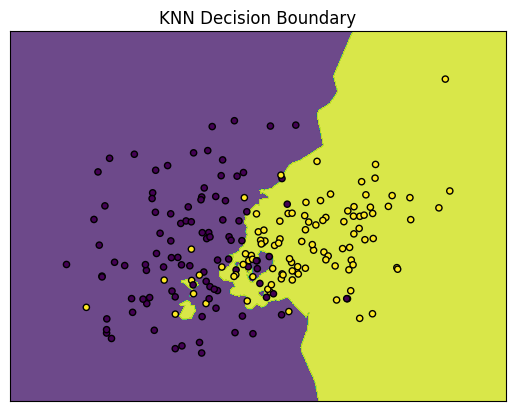

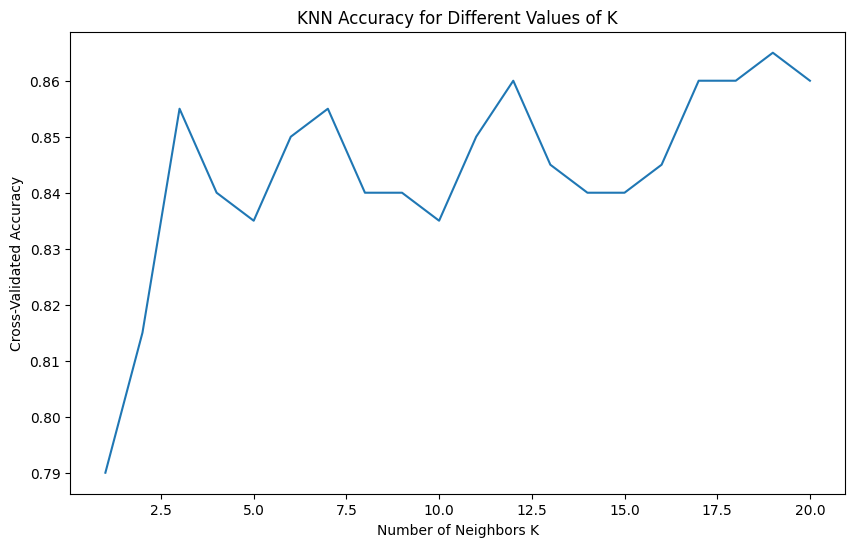

Best KNN Classifier Accuracy: 0.88
Best KNN Regressor MSE: 0.88


In [26]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=200, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1, random_state=42)

knn_clf = KNeighborsClassifier(n_neighbors=5)  #get 5 neighbors
knn_clf.fit(X, y)

def plot_decision_boundary(clf, X, y, ax):
    xmax, xmin = X[:, 0].max() + 1, X[:, 0].min() - 1
    ymax, ymin = X[:, 1].max() + 1, X[:, 1].min() - 1
    Xx, Yy = np.meshgrid(np.arange(xmin, xmax, 0.01),
                         np.arange(ymin, ymax, 0.01))
    prediction = clf.predict(np.c_[Xx.ravel(), Yy.ravel()])
    prediction = prediction.reshape(Xx.shape)
    ax.contourf(Xx, Yy, prediction, alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', s=20)
    ax.set_xlim(Xx.min(), Xx.max())
    ax.set_ylim(Yy.min(), Yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title("KNN Decision Boundary")

fig, ax = plt.subplots()
plot_decision_boundary(knn_clf, X, y, ax)
plt.show()

k_range = range(1, 21)
cv_scores = []

for i in k_range:
    k = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(k, X, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

plt.figure(figsize=(10, 6))
sns.lineplot(x=k_range, y=cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Accuracy for Different Values of K')
plt.show()

#set best k-value to knn model
yreg = y + np.random.randn(200)
knnreg = KNeighborsRegressor(n_neighbors=5)
knnreg.fit(X, yreg)

ypredc = knn_clf.predict(X)
acc = accuracy_score(y, ypredc)

ypredr = knnreg.predict(X)
mse = mean_squared_error(yreg, ypredr)

print(f"Best KNN Classifier Accuracy: {acc:.2f}")
print(f"Best KNN Regressor MSE: {mse:.2f}")